# Benchmarking ALBATROSS Predictions

## Imports

In [25]:
from goose import create
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import protfasta
from natsort import natsorted,ns 
import pandas as pd
import time
import matplotlib.pyplot as plt
import pickle
import sparrow
from glob import glob
import os

## define functions

In [30]:
def run_inference(proteins, network,use_scaled=False):
    start_time = time.time()
    if use_scaled:
        predictions = [getattr(protein.predictor,f"{network}")(use_scaled=True) for label, protein in benchmarking_proteins.items()]
    else:
        predictions = [getattr(protein.predictor,f"{network}")(use_scaled=False) for label, protein in benchmarking_proteins.items()]

    end_time = time.time()
    time_taken = end_time - start_time
    return predictions, time_taken

def plot_performance(times_taken,network_name,output_directory="benchmarking",color="red"):
    fig,ax = plt.subplots()
    sequence_length = list(times_taken.keys())
    iterations_per_second = 250 / np.array(list(times_taken.values()))
    scatter = ax.scatter(sequence_length,iterations_per_second,color=color,s=20)
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Sequence predictions / second (CPU)")
    plt.tight_layout()
    plt.savefig(f"{output_directory}/scaled_{network_name}_cpu_performance.pdf",dpi=300)
    return fig, ax, scatter


In [8]:
outer_list = []
for i in tqdm(range(250)):
    seqs = []
    for l in range(25, 751, 25):
        seqs.append(create.sequence(length=l))
    outer_list.append(seqs)

100%|█████████████████████████████████████████████████████████████████| 250/250 [00:37<00:00,  6.66it/s]


In [9]:
sequences = {i : sequence for i,sequence in enumerate(np.array(outer_list).T)}

In [13]:
# create a sample dataframe
df = pd.DataFrame.from_dict(sequences)

# create a list of columns to melt
cols_to_melt = df.columns.tolist()

# create a new dataframe to store the melted data
melted_df = pd.DataFrame(columns=['sequence', 'length'])

# loop over each column in the original dataframe
for col in cols_to_melt:
    # extract the length of the sequences in the column
    seq_len = len(df[col][0])
    # melt the column into a dataframe with two columns: 'sequence' and 'length'
    melted_col = pd.melt(df[[col]], value_name='sequence', var_name='length')
    # add the sequence length to the 'length' column of the melted dataframe
    melted_col['length'] = seq_len
    # append the melted column to the final melted dataframe
    melted_df = pd.concat([melted_df, melted_col], ignore_index=True)

# display the final melted dataframe
melted_df["header"] = [f"seq{i}" for i in range(len(melted_df))]
melted_df.tail()

,sequence,length,header
7495,TEEGDQSHNKTAEGDGNDSSHTAGSHHQTKQDTDHGAKKDNTGVST...,750,seq7495
7496,QQATKEEHEAHNESADSKEGQKREKGSNETHATDEEHKGNDHDNRA...,750,seq7496
7497,NSGDRHSEEHGNTHHNAETTKGNNNTHGGKNDGTKAKHTDNGAAGN...,750,seq7497
7498,NAQNKQDRKPAKDSDETTTHQKAQTSKAQTSQTQSTNKRTQHHAQG...,750,seq7498
7499,KHDNHGKDRKQRESHHGDHQKKSKENGGGPTEEGNQEADTTKTTDA...,750,seq7499


In [17]:
for length in set(melted_df["length"]):
    trimmed_df = melted_df[melted_df["length"] == length]
    headers = trimmed_df["header"].tolist()
    seqs = trimmed_df["sequence"].tolist()

    fastas = {header : sequence for header,sequence  in zip(headers,seqs)}
    os.makedirs("benchmarking",exist_ok=True)
    protfasta.write_fasta(fastas,f"benchmarking/seqs_of_length_{length}.fasta")

In [18]:
benchmarking_files = natsorted(glob("benchmarking/*fasta"))

In [28]:

# for network in ["end_to_end_distance","scaling_exponent",
#                 "asphericity","prefactor"]:
for network in ["radius_of_gyration","end_to_end_distance"]:  
# for network in ["radius_of_gyration","end_to_end_distance","scaling_exponent",
#                 "asphericity","prefactor"]:
    times_taken = {}
    print(network)
    for fasta_file in benchmarking_files:
        print(fasta_file)
        benchmarking_proteins = sparrow.read_fasta(fasta_file)
        length = len(list(benchmarking_proteins.values())[0])
        predictons, time_taken = run_inference(benchmarking_proteins,network=network,use_scaled=True)
        times_taken[length] = time_taken
    with open(f"benchmarking/scaled_{network}_predictions_per_second.pickle", "wb") as f:
        pickle.dump(times_taken, f)

radius_of_gyration
benchmarking/seqs_of_length_25.fasta
benchmarking/seqs_of_length_50.fasta
end_to_end_distance
benchmarking/seqs_of_length_25.fasta
benchmarking/seqs_of_length_50.fasta


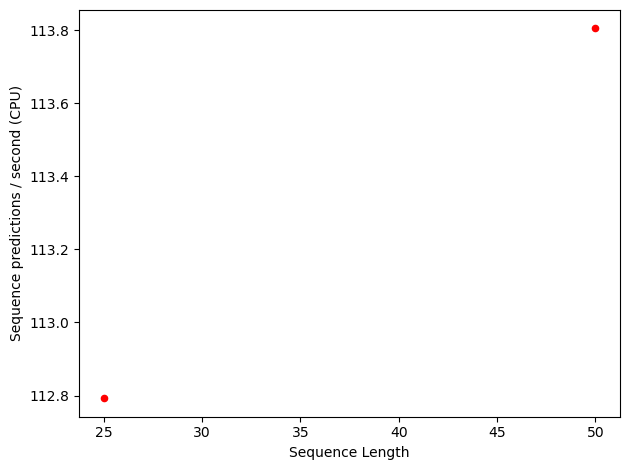

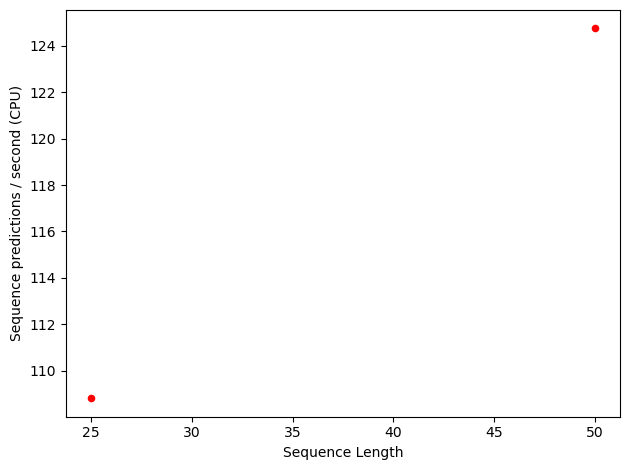

In [31]:
for network in ["radius_of_gyration","end_to_end_distance",]:#"scaling_exponent","asphericity","prefactor"]:
    times_taken = np.load(f"benchmarking/scaled_{network}_predictions_per_second.pickle",allow_pickle=True)

    fig, ax, scatter = plot_performance(times_taken,network_name=network)
